In [139]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import joblib

# 1. Load dataset

df = pd.read_csv("dataset.csv")

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())

Dataset loaded successfully!
Shape: (1319, 9)
   Age  Gender  Heart rate  Systolic blood pressure  Diastolic blood pressure  \
0   64       1          66                      160                        83   
1   21       1          94                       98                        46   
2   55       1          64                      160                        77   
3   64       1          70                      120                        55   
4   55       1          64                      112                        65   

   Blood sugar  CK-MB  Troponin    Result  
0        160.0   1.80     0.012  negative  
1        296.0   6.75     1.060  positive  
2        270.0   1.99     0.003  negative  
3        270.0  13.87     0.122  positive  
4        300.0   1.08     0.003  negative  


In [141]:
# 2. Data Cleaning & Preprocessing

# Handle missing values 
print("\nMissing values before cleaning:\n", df.isnull().sum())
df = df.dropna()
print("Missing values after cleaning:\n", df.isnull().sum())

# Encode categorical target
df['Result'] = df['Result'].map({'positive': 1, 'negative': 0})

# Encode gender if needed
if df['Gender'].dtype == 'object':
    le = LabelEncoder()
    df['Gender'] = le.fit_transform(df['Gender'])

# Detect outliers (IQR) and remove them
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print("After outlier removal:", df.shape)

# Split features and labels
X = df.drop('Result', axis=1)
y = df['Result']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Missing values before cleaning:
 Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64
Missing values after cleaning:
 Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64
After outlier removal: (789, 9)


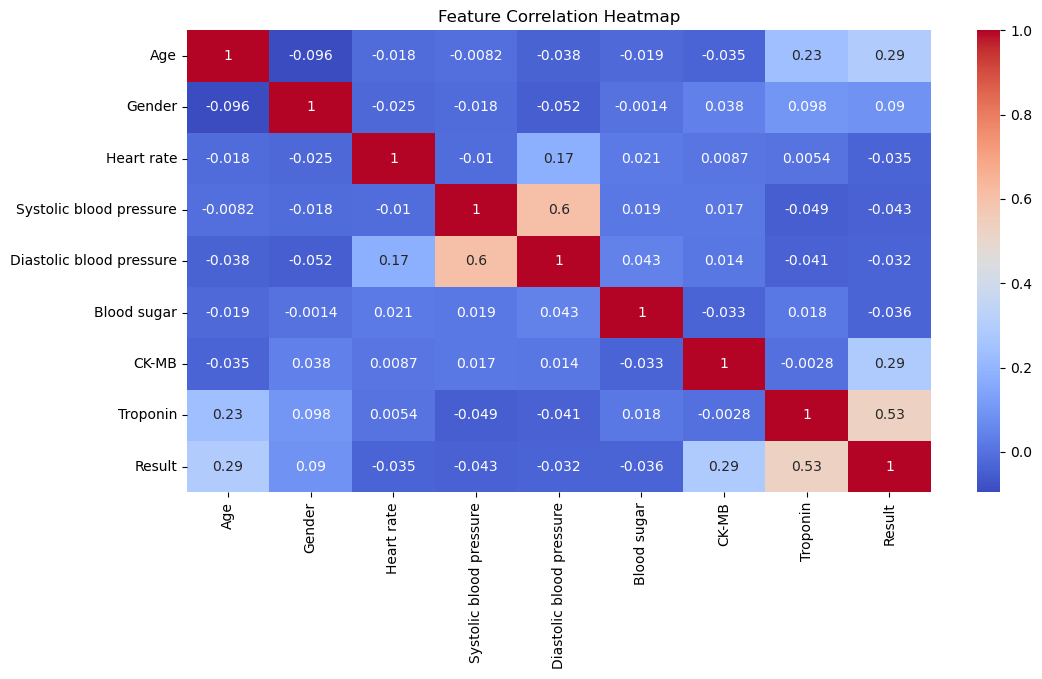

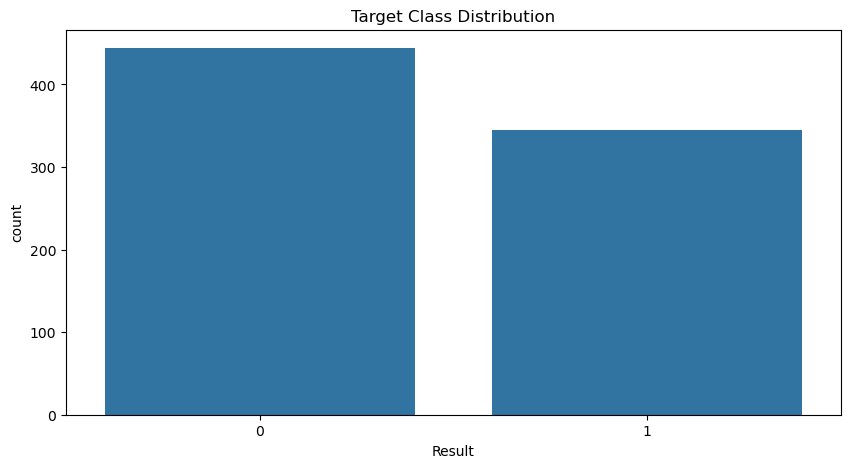

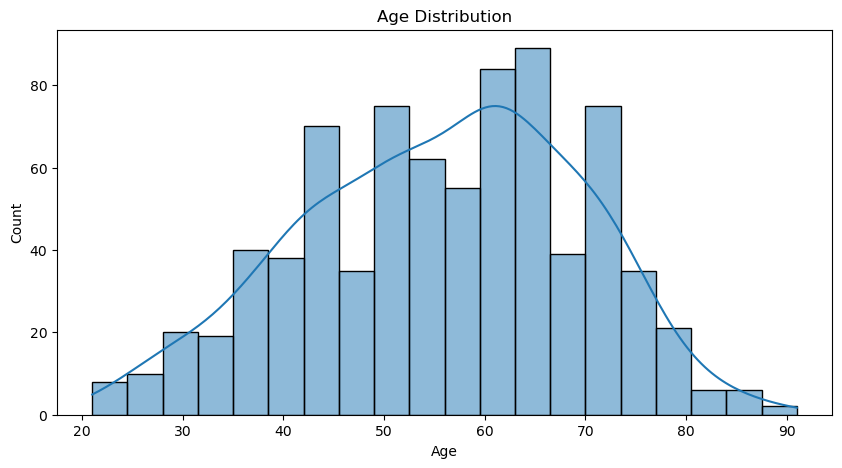

In [143]:
# 3. Exploratory Data Analysis 

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='Result', data=df)
plt.title("Target Class Distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

In [144]:
# 4. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Data split done")

Data split done


In [145]:
# 5. Random Forest Model + GridSearch

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("\n Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



Model Accuracy: 97.47 %
ROC-AUC Score: 0.9959

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        89
           1       0.99      0.96      0.97        69

    accuracy                           0.97       158
   macro avg       0.98      0.97      0.97       158
weighted avg       0.97      0.97      0.97       158



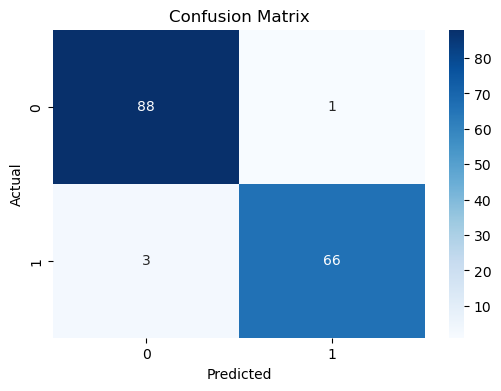

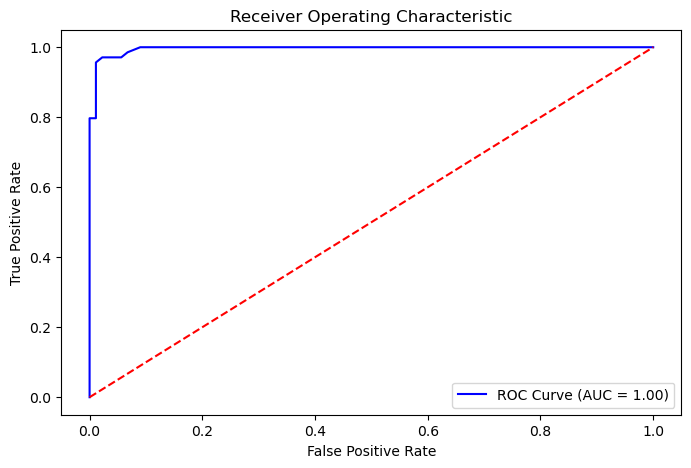

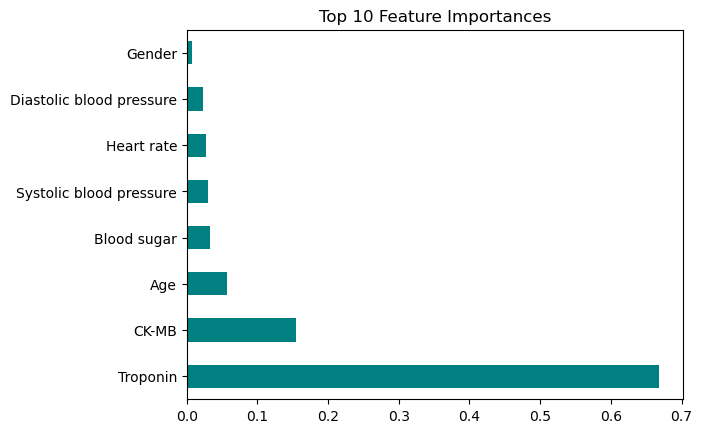

In [146]:
# 6. Model Evaluation

y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("\nModel Accuracy:", round(acc * 100, 2), "%")
print("ROC-AUC Score:", round(roc_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

# Feature Importance
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Feature Importances")
plt.show()

In [147]:
# 7. Save the Model & Scaler

joblib.dump(best_rf, "heart_attack_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [148]:
# 8. Test Model with Manual Input

manual_input = {
    'Age': 25,
    'Gender': 1,
    'Heart rate': 60,
    'Systolic blood pressure': 120,
    'Diastolic blood pressure': 55,
    'Blood sugar': 270,
    'CK-MB': 13.87,
    'Troponin': 0.003, 
}

# Convert to DataFrame
manual_df = pd.DataFrame([manual_input])

# Load saved scaler and model
loaded_scaler = joblib.load("scaler.pkl")
loaded_model = joblib.load("heart_attack_rf_model.pkl")

# Scale manual data
manual_scaled = loaded_scaler.transform(manual_df)

# Predict
prediction = loaded_model.predict(manual_scaled)[0]
probability = loaded_model.predict_proba(manual_scaled)[0][1]

print("\nManual Test Data:", manual_input)
print("Predicted Result:", "Heart Attack Risk (Positive)" if prediction == 1 else "No Heart Attack (Negative)")
print("Probability of Heart Attack:", round(probability * 100, 2), "%")



Manual Test Data: {'Age': 25, 'Gender': 1, 'Heart rate': 60, 'Systolic blood pressure': 120, 'Diastolic blood pressure': 55, 'Blood sugar': 270, 'CK-MB': 13.87, 'Troponin': 0.003}
Predicted Result: Heart Attack Risk (Positive)
Probability of Heart Attack: 66.0 %


# 

In [152]:
for t in [0.005, 0.014, 0.02, 0.05, 0.1, 1.0]:
    manual_input['Troponin'] = t
    manual_scaled = loaded_scaler.transform(pd.DataFrame([manual_input]))
    pred = loaded_model.predict(manual_scaled)[0]
    prob = loaded_model.predict_proba(manual_scaled)[0][1]
    print(f"Troponin={t} -> Prob={prob:.3f} -> {'Positive' if pred==1 else 'Negative'}")


Troponin=0.005 -> Prob=0.650 -> Positive
Troponin=0.014 -> Prob=0.620 -> Positive
Troponin=0.02 -> Prob=0.920 -> Positive
Troponin=0.05 -> Prob=0.930 -> Positive
Troponin=0.1 -> Prob=0.930 -> Positive
Troponin=1.0 -> Prob=0.930 -> Positive
